In [12]:
# MESH is toolkit for facets and meshes
# FEM is function toolkit
# IO is file manager
# PLOT is plot manager
# MPI for multyprocessors operation
# UFL is folrmula translator
# PETS is linear algebra solver

from dolfinx import mesh, fem, io, plot
import ufl
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import numpy as np
import matplotlib.pyplot as plt


class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)

In [13]:
# def_uD = lambda x: 3 * x[0]**2 - 3 * x[0]
# def_uD = lambda x:- x[0]
def_uD = lambda x: np.where(x[0] >= 0.5, x[0]**2, 0)
def_f = 6
N = 100

# Solver

In [14]:
domain = mesh.create_interval(MPI.COMM_WORLD, N - 1, [0, 1])
V = fem.FunctionSpace(domain, ('Lagrange', 1))

In [15]:
uD = fem.Function(V)
uD.interpolate(def_uD)
domain.topology.create_connectivity(
    domain.topology.dim - 1,
    domain.topology.dim,
    )
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(
    V,
    domain.topology.dim - 1,
    boundary_facets,
    )
bcs = fem.dirichletbc(uD, boundary_dofs)

In [16]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
f = fem.Constant(V, ScalarType(def_f))
dot = Infix(ufl.dot)
grad = ufl.grad
dx = ufl.dx

F= (grad(u)|dot|grad(v)) * dx +\
    f*v*dx

In [17]:
problem = fem.petsc.LinearProblem(
    ufl.lhs(F),
    ufl.rhs(F),
    bcs=[bcs],
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
        }
    )
uS = problem.solve()

In [18]:
# L2 error
V_err = fem.FunctionSpace(domain, ('CG', 2))
u_err = fem.Function(V_err)
u_err.interpolate(def_uD)
L2 = fem.form(((uS - u_err)|dot|(uS - u_err)) * dx)
L1 = fem.form((uS - u_err) * dx)

err_local = fem.assemble_scalar(L2)
err_L2 = np.sqrt(domain.comm.allreduce(err_local, op=MPI.SUM))
err_local1 = fem.assemble_scalar(L1)
err_L12 = np.abs(domain.comm.allreduce(err_local1, op=MPI.SUM))

err_L1 = np.max(np.abs(uS.x.array - uD.x.array))

# Graph

In [19]:
print(
    f' L1= {err_L12:.2e} \n L2 norm = {err_L2:.2e} \n L1 norm = {err_L1:.2e}'
    )

 L1= 2.92e-01 
 L2 norm = 3.20e-01 
 L1 norm = 5.00e-01


In [24]:
uS.function_space.mesh ==domain

True

In [25]:
class Graph:

    @staticmethod
    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    @staticmethod
    def line_collision(domain, line_cord):
        """Generate points and cells of colliding domain and line

        Args:
            domain (mesh): Domain
            line_cord (array): 3D line contervertor of coordinates 

        Returns:
            Tuple: Collision points and collision cells
        """
        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells_on_line = []
        points_on_line = []
        cell_candidates = dolfinx.geometry.compute_collisions(
            bb_tree, line_cord.T
            )
        colliding_cells = dolfinx.geometry.compute_colliding_cells(
            domain, cell_candidates, line_cord.T
            )
        for i, point in enumerate(line_cord.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_line.append(point)
                cells_on_line.append(colliding_cells.links(i)[0])

        points_on_line = np.array(points_on_line, dtype=np.float64)

        return (points_on_line, cells_on_line)

    @staticmethod
    def graph1D(fig, ax, lists, points_on=False):
        """Create graph from fem.Function

        Args:
            fig (plt.Figure): Figure
            lists (fem.Function, str): List of (u, title)
            points_on (bool): If true create scatter
        """
        for list in lists:
            u, title = list
            x_cord = u.function_space.mesh.geometry.x[:, 0]
            y_cord = u.x.array
            ax.set_title(title)
            if points_on: ax.scatter(x_cord, y_cord)
            ax.plot(x_cord, y_cord, label=title)

        ax.legend(loc='upper left', facecolor='yellow')
        return

    @staticmethod
    def graph2D(fig, lists, natural_show=False, points_on=False):
        """Create graph from fem.Function

        Args:
            fig (plt.Figure): Figure
            lists (fem.Function , plt.Axes, str): List of (u, curent axes, title)
            natural_show (bool): True = tripcolor, False = tricontourf
            points_on (bool): True = set points
        """

        for list in lists:
            u, ax, title = list
            dofs = u.function_space.tabulate_dof_coordinates()
            ax.set_title(title)
            data = Graph.data_construct(dofs, u.x.array)

            if points_on:
                ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

            if natural_show:
                plot = ax.tripcolor(*data)
            else:
                try:
                    levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                    plot = ax.tricontourf(*data, levels=levels)
                except:
                    print(f'{title} - error')

            ax.set_aspect(1)
            fig.colorbar(plot, ax=ax)
        return


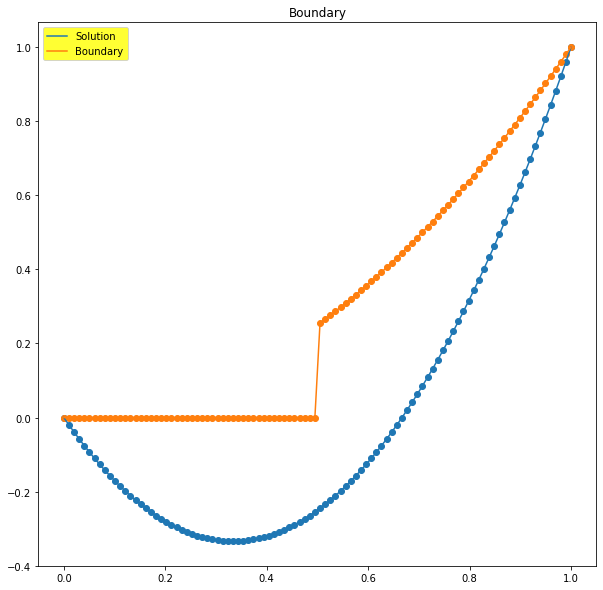

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
Graph.graph1D(
    fig=fig,
    ax=ax,
    points_on=True,
    lists=[[uS,'Solution'],
           [uD,'Boundary']],
    )
